In [1]:
from google.cloud import storage
import os
from io import BytesIO
import pandas as pd
import numpy as np

#Connect to GCP bucket and assign the bucket_name and specify the file name
bucket_name = "ychou-bucket1" #Assign the bucket name where your file is stored
storage_client = storage.Client()

bucket = storage_client.get_bucket(bucket_name)

In [2]:
blob = storage.blob.Blob("US_births2018_processed3.csv",bucket)

In [3]:
# Convert to a pandas dataframe
content = blob.download_as_string()
df_processed = pd.read_csv(BytesIO(content))

In [4]:
del content

In [5]:
#df_processed = df_processed.drop(columns = ['Unnamed: 0', 'MAGE_IMPFLG'])


In [6]:
#df_processed = df_processed.rename(columns={"MRAVE6": "MRACE6"})

In [7]:
#df_processed = df_processed.drop(columns = ['DLMP_MM','DOB_MM', 'DOB_TT','DOB_WK', 'ILLB_R','ILOP_R','ILP_R',
#                                           'DWgt_R', 'PWgt_R'])

In [8]:
#df_processed['DMAR'].value_counts()

In [9]:
#list1 = [1, 2]
#df_processed = df_processed[df_processed.DMAR.isin(list1)]

In [10]:
#df_processed = df_processed.drop(columns = ['MTRAN','IP_GON'])

In [11]:
#df_processed.columns

In [12]:
#df_processed.to_csv('US_births2018_processed3.csv')

In [13]:
# import package
from pyspark.sql.types import *
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import Row
from pyspark.sql import SparkSession

In [14]:
spark = SparkSession.builder.appName('ml-bank').getOrCreate()

In [15]:
#from pyspark.sql.types import *

#mySchema = StructType([ StructField("ATTEND", LongType(), True)\
#                       ,StructField("BFACIL", IntegerType(), True)\
#                       ,StructField("BMI", DoubleType(), True)\
#                       ,StructField("CIG_0", LongType(), True)\
#                       ,StructField("DBWT", LongType(), True)\
#                       ,StructField("DLMP_MM", LongType(), True)\
#                       ,StructField("DMAR", LongType(), True)\
#                      ,StructField("FAGECOMB", LongType(), True)\
#                       ,StructField("FEDUC", LongType(), True)\
#                       ,StructField("FHISPX", LongType(), True)\
#                       ,StructField("FRACE6", LongType(), True)\
#                       ,StructField("IP_GON", StringType(), True)\
#                       ,StructField("MAGER", LongType(), True)\
#                       ,StructField("MBSTATE_REC", LongType(), True)\
#                       ,StructField("MEDUC", LongType(), True)\
#                       ,StructField("MHISPX", LongType(), True)\
#                       ,StructField("MM_AICU", StringType(), True)\
#                       ,StructField("MRACE6", IntegerType(), True)])

In [16]:
#create spark dataframe
df = spark.createDataFrame(df_processed[:1200000])

In [17]:
del df_processed

In [18]:
df.printSchema()

root
 |-- Unnamed: 0: long (nullable = true)
 |-- ATTEND: long (nullable = true)
 |-- BFACIL: long (nullable = true)
 |-- BMI: double (nullable = true)
 |-- CIG_0: long (nullable = true)
 |-- DBWT: long (nullable = true)
 |-- DMAR: long (nullable = true)
 |-- FAGECOMB: long (nullable = true)
 |-- FEDUC: long (nullable = true)
 |-- FHISPX: long (nullable = true)
 |-- FRACE6: long (nullable = true)
 |-- MAGER: long (nullable = true)
 |-- MBSTATE_REC: long (nullable = true)
 |-- MEDUC: long (nullable = true)
 |-- MHISPX: long (nullable = true)
 |-- MM_AICU: string (nullable = true)
 |-- MRACE6: long (nullable = true)
 |-- M_Ht_In: long (nullable = true)
 |-- NO_INFEC: long (nullable = true)
 |-- NO_MMORB: long (nullable = true)
 |-- NO_RISKS: long (nullable = true)
 |-- PAY_REC: long (nullable = true)
 |-- PRECARE: long (nullable = true)
 |-- PREVIS: long (nullable = true)
 |-- PRIORDEAD: long (nullable = true)
 |-- PRIORLIVE: long (nullable = true)
 |-- PRIORTERM: long (nullable = true)


In [19]:
#timeseries and unuseful features
#'DLMP_MM''DLMP_YY''DOB_MM' 'DOB_TT''DOB_WK' 'ILLB_R''ILOP_R''ILP_R'
#multicollinearity
#BMI:DWGT_R PWGT_R 

In [20]:
#Preparing Data for Machine Learning
#merges multiple columns into a vectorcolumn.
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['ATTEND', 'BFACIL', 'DMAR', 'FEDUC', 'FHISPX', 'FRACE6','MBSTATE_REC','MEDUC',
                      'MHISPX', 'MM_AICU', 'MRACE6', 'NO_INFEC', 'NO_MMORB', 'NO_RISKS', 'PAY_REC',
                      'RDMETH_REC', 'RESTATUS', 'RF_CESARN', 'SEX']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'ANOMALY', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['BMI', 'CIG_0', 'DBWT', 'FAGECOMB', 'MAGER', 'M_Ht_In', 'PRECARE', 'PREVIS', 'PRIORDEAD',
              'PRIORLIVE', 'PRIORTERM', 'RF_CESARN', 'WTGAIN']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [21]:
#chain multiple Transformers and Estimators together to specify our machine learning workflow
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features']
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)



In [22]:
#checked processed data
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,0,0,0,0,0
features,"(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


In [23]:
#split train and test
train, test = df.randomSplit([0.7, 0.3], seed = 2020)

In [24]:
del df

In [25]:
#LogisticRegression
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=5)
lrModel = lr.fit(train)

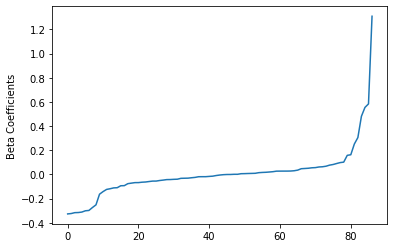

In [26]:
import matplotlib.pyplot as plt
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

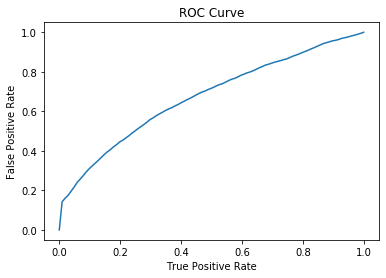

Training set areaUnderROC: 0.6723613815296275


In [27]:
#ROC LogisticRegression
trainingSummary_lr = lrModel.summary
roc = trainingSummary_lr.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary_lr.areaUnderROC))

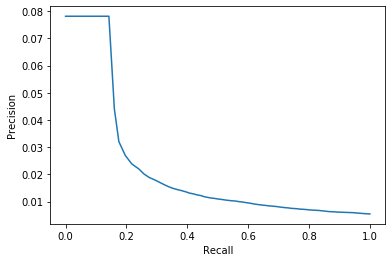

In [28]:
#recall precision LogisticRegression
pr = trainingSummary_lr.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [29]:
#make predictions on test
predictions_lr = lrModel.transform(test)
predictions_lr.select('label', 'rawPrediction', 'prediction', 'probability').show(5)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[5.91351146701550...|       0.0|[0.99730460495561...|
|  0.0|[5.51959932244528...|       0.0|[0.99600854226350...|
|  0.0|[5.86339419743987...|       0.0|[0.99716646930686...|
|  0.0|[5.49630985479974...|       0.0|[0.99591487660839...|
|  0.0|[6.05583124673509...|       0.0|[0.99766132945969...|
+-----+--------------------+----------+--------------------+
only showing top 5 rows



In [30]:
#caculate accuracy precision recall f1
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator2 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator3 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
evaluator4 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
accuracy = evaluator1.evaluate(predictions_lr)
precision = evaluator2.evaluate(predictions_lr)
recall = evaluator3.evaluate(predictions_lr)
f1 = evaluator4.evaluate(predictions_lr)
print("Test Accuracy = %g" % (accuracy))
print("Test weightedPrecision = %g" % (precision))
print("Test weightedRecall = %g" % (recall))
print("Test F1 = %g" % (f1))

Test Accuracy = 0.994467
Test weightedPrecision = 0.988964
Test weightedRecall = 0.994467
Test F1 = 0.991708


In [31]:
#evaluate prediction on test
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions_lr))

Test Area Under ROC 0.6819707967135722


In [32]:
del lrModel
del predictions_lr

In [33]:
#decision tree
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions_dt = dtModel.transform(test)
predictions_dt.select('label', 'rawPrediction', 'prediction', 'probability').show(5)

+-----+-----------------+----------+--------------------+
|label|    rawPrediction|prediction|         probability|
+-----+-----------------+----------+--------------------+
|  0.0|[835396.0,4606.0]|       0.0|[0.99451667972219...|
|  0.0|[835396.0,4606.0]|       0.0|[0.99451667972219...|
|  0.0|[835396.0,4606.0]|       0.0|[0.99451667972219...|
|  0.0|[835396.0,4606.0]|       0.0|[0.99451667972219...|
|  0.0|[835396.0,4606.0]|       0.0|[0.99451667972219...|
+-----+-----------------+----------+--------------------+
only showing top 5 rows



In [34]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator2 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator3 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
evaluator4 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
accuracy = evaluator1.evaluate(predictions_dt)
precision = evaluator2.evaluate(predictions_dt)
recall = evaluator3.evaluate(predictions_dt)
f1 = evaluator4.evaluate(predictions_dt)
print("Test Accuracy = %g" % (accuracy))
print("Test weightedPrecision = %g" % (precision))
print("Test weightedRecall = %g" % (recall))
print("Test F1 = %g" % (f1))

Test Accuracy = 0.994467
Test weightedPrecision = 0.988964
Test weightedRecall = 0.994467
Test F1 = 0.991708


In [35]:
#ROC decision tree
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions_dt, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.5


In [36]:
del dtModel
del predictions_dt

In [37]:
#RandomForest
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions_rf = rfModel.transform(test)
predictions_rf.select('label', 'rawPrediction', 'prediction', 'probability').show(5)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[19.9041238575498...|       0.0|[0.99520619287749...|
|  0.0|[19.9041238575498...|       0.0|[0.99520619287749...|
|  0.0|[19.9004243675603...|       0.0|[0.99502121837801...|
|  0.0|[19.8958469891779...|       0.0|[0.99479234945889...|
|  0.0|[19.9041238575498...|       0.0|[0.99520619287749...|
+-----+--------------------+----------+--------------------+
only showing top 5 rows



In [38]:
#check feature importance
#write a function to better interpret output
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [39]:
ExtractFeatureImp(rfModel.featureImportances, predictions_rf, "features").head(10)

,idx,name,score
2,76,DBWT,0.119931
7,81,PREVIS,0.090513
72,59,RESTATUSclassVec_1,0.081174
43,30,MBSTATE_RECclassVec_2,0.079691
52,39,MHISPXclassVec_1,0.064351
32,19,FHISPXclassVec_1,0.061228
73,60,RESTATUSclassVec_2,0.058424
4,78,MAGER,0.051292
6,80,PRECARE,0.049141
5,79,M_Ht_In,0.042901


In [40]:
#ROC RandomForest
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.6909498199049732


In [41]:
# Select (prediction, true label) and compute test error
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator2 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator3 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
evaluator4 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
accuracy = evaluator1.evaluate(predictions_rf)
precision = evaluator2.evaluate(predictions_rf)
recall = evaluator3.evaluate(predictions_rf)
f1 = evaluator4.evaluate(predictions_rf)
print("Test Accuracy = %g" % (accuracy))
print("Test weightedPrecision = %g" % (precision))
print("Test weightedRecall = %g" % (recall))
print("Test F1 = %g" % (f1))

Test Accuracy = 0.994467
Test weightedPrecision = 0.988964
Test weightedRecall = 0.994467
Test F1 = 0.991708


In [42]:
del rfModel
del predictions_rf

In [43]:
#GBT
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions_gbt = gbtModel.transform(test)
predictions_gbt.select('label', 'rawPrediction', 'prediction', 'probability').show(5)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[1.31313358243505...|       0.0|[0.93253307642197...|
|  0.0|[1.31286870697603...|       0.0|[0.93249973943208...|
|  0.0|[1.31313358243505...|       0.0|[0.93253307642197...|
|  0.0|[1.30309451273945...|       0.0|[0.93125883421770...|
|  0.0|[1.31313358243505...|       0.0|[0.93253307642197...|
+-----+--------------------+----------+--------------------+
only showing top 5 rows



In [44]:
ExtractFeatureImp(gbtModel.featureImportances, predictions_gbt, "features").head(10)

,idx,name,score
74,61,RESTATUSclassVec_3,0.518754
73,60,RESTATUSclassVec_2,0.157496
72,59,RESTATUSclassVec_1,0.084976
2,76,DBWT,0.062291
7,81,PREVIS,0.035088
32,19,FHISPXclassVec_1,0.016353
3,77,FAGECOMB,0.013053
4,78,MAGER,0.012419
6,80,PRECARE,0.009843
52,39,MHISPXclassVec_1,0.009363


In [45]:
# Select (prediction, true label) and compute test error
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator2 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator3 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
evaluator4 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
accuracy = evaluator1.evaluate(predictions_gbt)
precision = evaluator2.evaluate(predictions_gbt)
recall = evaluator3.evaluate(predictions_gbt)
f1 = evaluator4.evaluate(predictions_gbt)
print("Test Accuracy = %g" % (accuracy))
print("Test weightedPrecision = %g" % (precision))
print("Test weightedRecall = %g" % (recall))
print("Test F1 = %g" % (f1))

Test Accuracy = 0.995633
Test weightedPrecision = 0.995592
Test weightedRecall = 0.995633
Test F1 = 0.994233


In [46]:
#ROC GBT
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7404542304567959


In [47]:
del gbtModel
del predictions_gbt

In [48]:
del test
del train

In [49]:
#from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
#paramGrid = (ParamGridBuilder()
#             .addGrid(gbt.maxDepth, [2, 4, 6])
#             .addGrid(gbt.maxBins, [20, 60])
#             .addGrid(gbt.maxIter, [10, 20])
#             .build())
#cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
#cvModel = cv.fit(train)
#predictions_cv = cvModel.transform(test)
#evaluator.evaluate(predictions_cv)

In [50]:
#evaluator1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
#evaluator2 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
#evaluator3 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
#evaluator4 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
#accuracy = evaluator1.evaluate(predictions_cv)
#precision = evaluator2.evaluate(predictions_cv)
#recall = evaluator3.evaluate(predictions_cv)
#f1 = evaluator4.evaluate(predictions_cv)
#print("Test Accuracy = %g" % (accuracy))
#print("Test weightedPrecision = %g" % (precision))
#print("Test weightedRecall = %g" % (recall))
#print("Test F1 = %g" % (f1))

In [51]:
#solution of imblanced classification
#Always split into test and train sets BEFORE trying oversampling techniques